# Marketing Mix Modeling in Lemonade
## Notebook containing code for the plots and data in the paper

#### Imports and Cosmetics 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from matplotlib import font_manager
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from scipy.stats import halfnorm

In [4]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MaxAbsScaler

from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [5]:
font_manager.fontManager.addfont(r"Lato/Lato-Regular.ttf")

In [6]:
lato_font = r"Lato\Lato-Regular.ttf"

In [7]:
sns.set_style(
    "darkgrid",
    rc={"figure.facecolor": "white", "lines.color": "#12698A"},  # "font.family": "Lato"
)

In [8]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
np.random.seed(seed)

In [9]:
def reach(x, mu):
    return (1 - np.exp(-x / mu)) / (1 + np.exp(-x / mu))


def carryover(x, alpha, L=16):
    w = np.array([np.power(alpha, i) for i in range(L)])
    x_t = np.stack([np.concatenate([np.zeros(i), x[: len(x) - i]]) for i in range(L)])
    return np.dot(w / np.sum(w), x_t)

In [10]:
def evaluate_model(y_true, y_pred, y_train=None):
    y_train = y_true if y_train is None else y_train
    return {
        "r2": round(r2_score(y_true=y_true, y_pred=y_pred), 3),
        "mape": round(mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), 3),
        "mase": round(mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred, y_train=y_train, sp=52), 3)
    }

### General Plots 

#### Saturation (Reach)

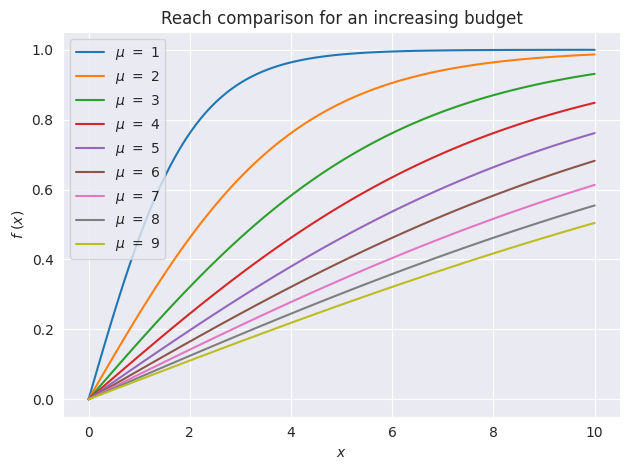

In [11]:
x = np.linspace(0, 10, 100)
for mu in np.arange(1, 10, 1):
    plt.plot(x, reach(x, mu), label=f"$\\mu\ =\ {round(mu, 2)}$")

plt.title("Reach comparison for an increasing budget")
plt.legend()
plt.ylabel("$f\ (x)$")
plt.xlabel("$x$")
plt.tight_layout();

#### Carryover (Adstock) 

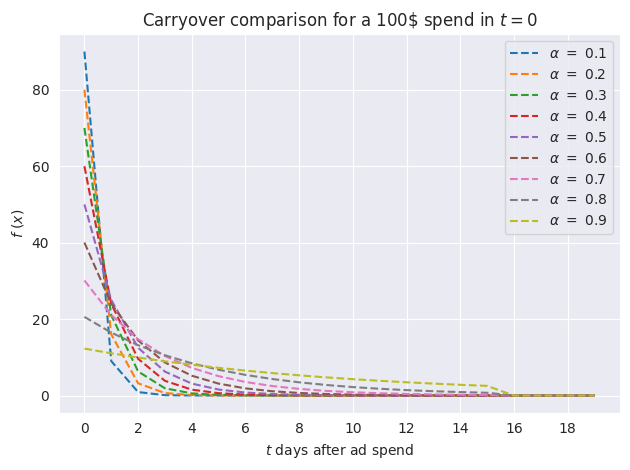

In [12]:
x = np.concatenate([np.array([100]), np.zeros(19)])
for alpha in np.arange(0.1, 1, 0.1):
    plt.plot(
        range(len(x)),
        carryover(x, alpha),
        linestyle="dashed",
        label=f"$\\alpha\ =\ {round(alpha, 2)}$",
    )

plt.title("Carryover comparison for a 100\$ spend in $t=0$")
plt.legend()
plt.xticks(range(0, len(x), 2))
plt.ylabel("$f\ (x)$")
plt.xlabel("$t$ days after ad spend")
plt.tight_layout();

# Data Simulation

Built with a lot of insperation from this great [example](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

The simulated data will consist of daily spend in 3 channels: $X_1, X_2 , X_3$ 

across the dates: $2018-04-01 \to 2021-09-01$

We'll use the following actual latent variables:

|       | Saturation $(\mu)$ | Carryover $(\alpha)$ | Regression Coefficient $(\beta)$ |
| ------| ------------------ | -------------------- |--------------------------------- |
| $X_1$ |        4.0         |           0.4        |                3.0               |
| $X_2$ |        3.0         |           0.2        |                2.0               |


In [13]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

# apply saturation transformation
mu1: float = 4.0
mu2: float = 3.0

# regression coefficients
beta_1 = 3.0
beta_2 = 2.0

betas = [beta_1, beta_2]

In [14]:
# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
)
n = df.shape[0]

# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

df["x1_carryover"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_carryover"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x1_carryover_reach"] = logistic_saturation(
    x=df["x1_carryover"].to_numpy(), lam=mu1
).eval()

df["x2_carryover_reach"] = logistic_saturation(
    x=df["x2_carryover"].to_numpy(), lam=mu2
).eval()
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

df["y"] = (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + beta_1 * df["x1_carryover_reach"]
    + beta_2 * df["x2_carryover_reach"]
    + df["epsilon"]
)

contribution_share_x1: float = (beta_1 * df["x1_carryover_reach"]).sum() / (
    beta_1 * df["x1_carryover_reach"] + beta_2 * df["x2_carryover_reach"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_carryover_reach"]).sum() / (
    beta_1 * df["x1_carryover_reach"] + beta_2 * df["x2_carryover_reach"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


In [15]:
columns_to_keep = [
    "date",
    "y",
    "x1",
    "x2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
data.head()

,date,y,x1,x2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,120


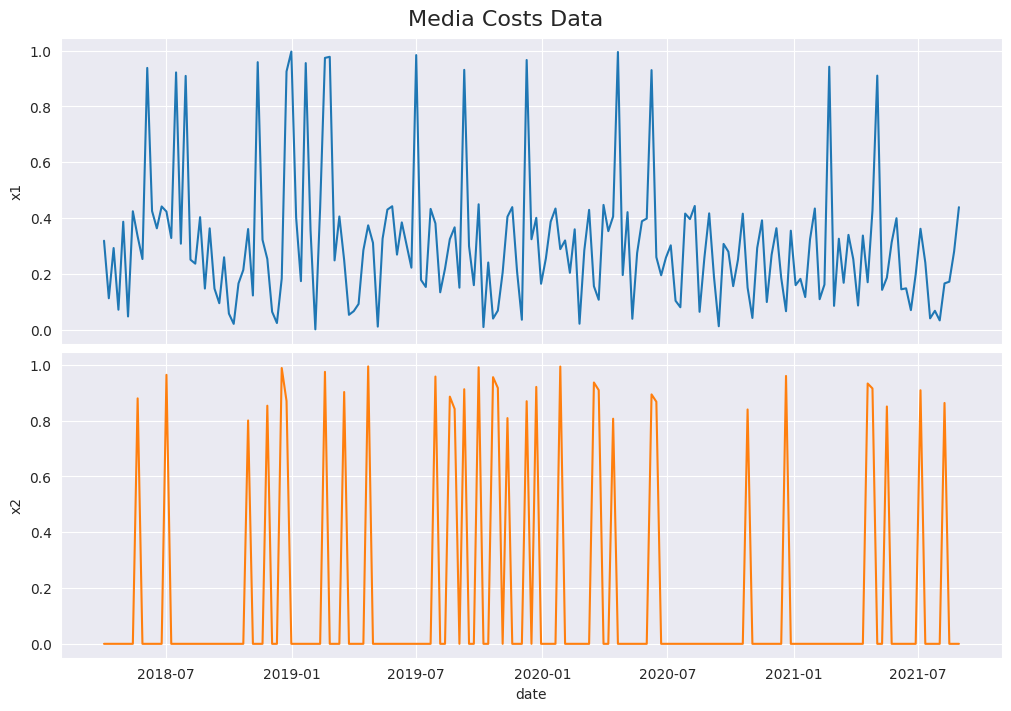

In [16]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

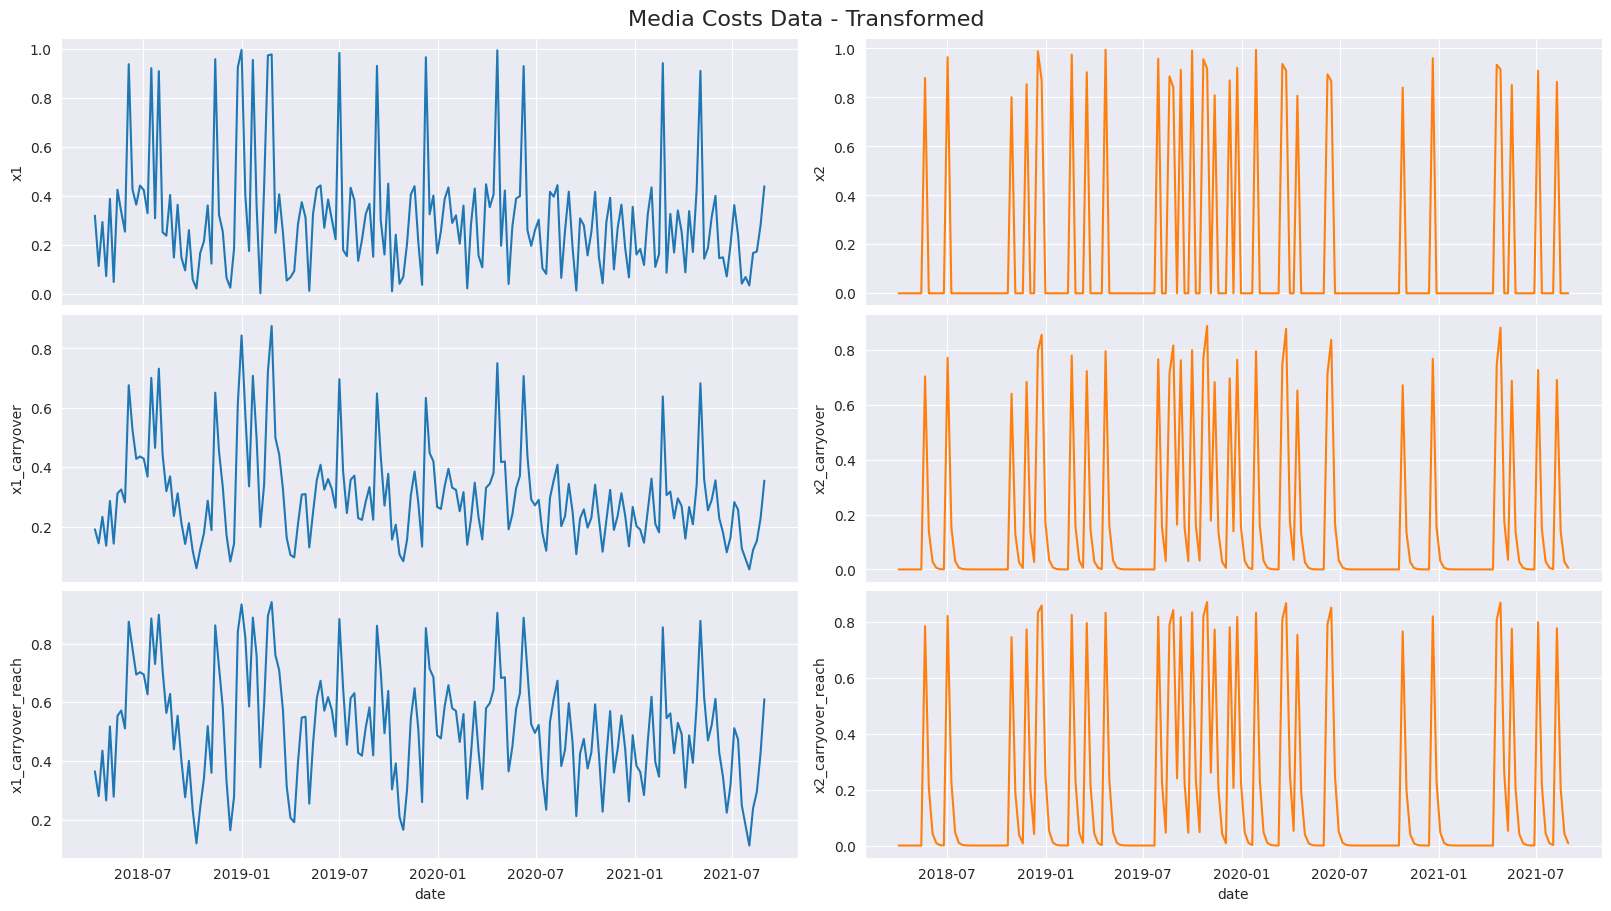

In [17]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date", y="x1_carryover", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="x2_carryover", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date", y="x1_carryover_reach", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="x2_carryover_reach", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

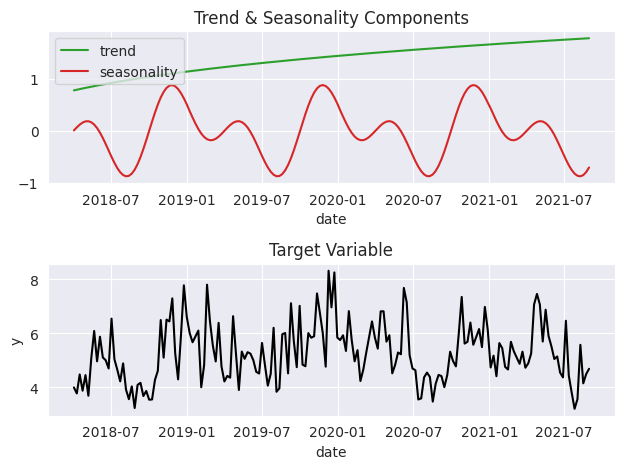

In [18]:
fig, axes = plt.subplots(nrows=2)
sns.lineplot(x="date", y="trend", color="C2", label="trend", data=df, ax=axes[0])
sns.lineplot(x="date", y="seasonality", color="C3", label="seasonality", data=df, ax=axes[0])
axes[0].legend(loc="upper left")
axes[0].set(title="Trend & Seasonality Components", xlabel="date", ylabel=None)

sns.lineplot(x="date", y="y", color="black", data=df, ax=axes[1])
axes[1].set(title="Target Variable", xlabel="date", ylabel="y")
fig.tight_layout();

In [19]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

x1    0.65632
x2    0.34368
dtype: float64

In [20]:
LABEL = "y"
CHANNELS = ["x1", "x2"]
n_channels = 2

X = data.drop(LABEL, axis=1)
y = data[LABEL]

In [21]:
roas_1 = (beta_1 * df["x1_carryover_reach"]).sum() / df["x1"].sum()
roas_2 = (beta_2 * df["x2_carryover_reach"]).sum() / df["x2"].sum()

roas_df = pd.DataFrame([roas_1, roas_2], index=CHANNELS, columns=["actual"])

In [22]:
param_df = pd.DataFrame(
    [alpha1, alpha2, mu1, mu2, beta_1, beta_2],
    index=["alpha1", "alpha2", "mu1", "mu2", "beta_1", "beta_2"],
    columns=["actual"],
)

# PyMC-Marketing 

In [23]:
MODEL_NAME = "pymc-marketing"

In [24]:
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
prior_beta = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_beta.tolist()

[2.1775326025486734, 1.1402608773919387]

In [25]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=4)
custom_beta_channel_prior = {
    "beta_channel": {"sigma": prior_beta, "dims": ("channel",)}
}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}

In [26]:
mmm = DelayedSaturatedMMM(
    model_config=my_model_config,
    sampler_config={"progressbar": True},
    date_column="date",
    channel_columns=CHANNELS,
    adstock_max_lag=16,
    yearly_seasonality=2,
)

In [27]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng, tune=500, draws=500);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_fourier]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 83 seconds.
Sampling: [alpha, beta_channel, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


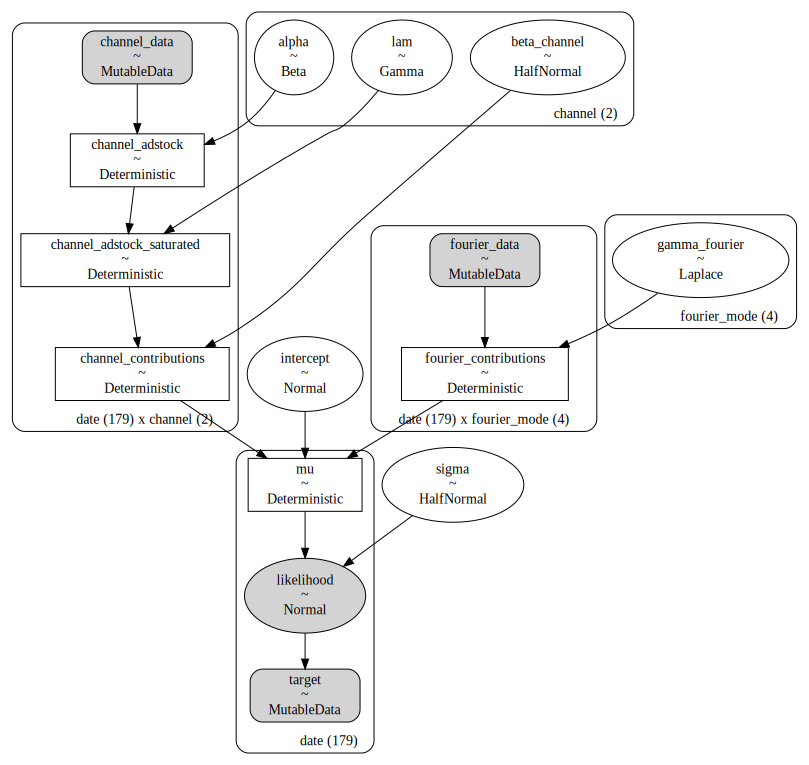

In [28]:
pm.model_to_graphviz(model=mmm.model)

In [29]:
param_df["pymc-marketing"] = (
    mmm.idata.posterior.mean(dim=["chain", "draw"])[["beta_channel", "lam", "alpha"]]
    .to_pandas()
    .melt()["value"]
    .round(2)
    .values
)

In [ ]:
y_pred = mmm.idata.posterior_predictive.mean(
    dim=["chain", "draw"]
).likelihood.to_numpy()

y_pred = mmm.target_transformer.inverse_transform(y_pred.reshape(-1,1))

In [32]:
eval_dict = evaluate_model(df[LABEL].values, y_pred)
performance_df = pd.DataFrame(
    eval_dict.values(), index=eval_dict.keys(), columns=[MODEL_NAME]
)
performance_df

,pymc-marketing
r2,0.898
mape,0.056
mase,0.281


In [33]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = channel_contribution_original_scale.stack(sample=("chain", "draw")).sum(
    "date"
)
roas_df[MODEL_NAME] = roas_samples.mean("sample") / data[CHANNELS].sum()

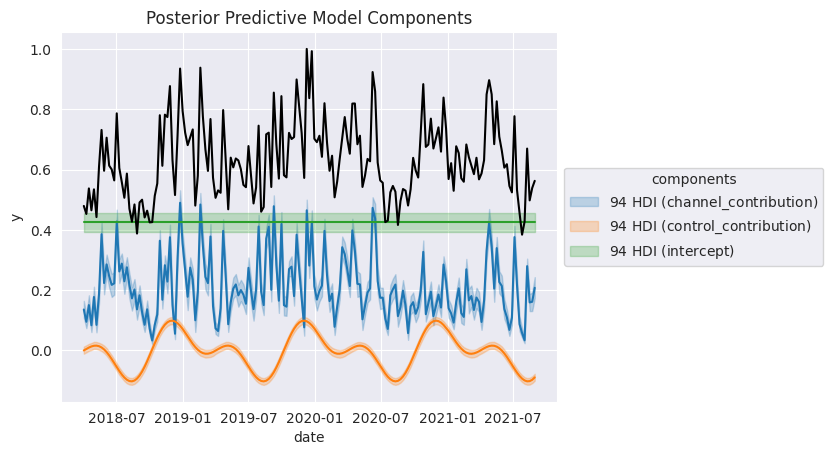

In [34]:
mmm.plot_components_contributions();

In [35]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#2A76E4", "#b7b7b7"])

# KTR

In [36]:
MODEL_NAME = "ktr"

In [37]:
from orbit.diagnostics.plot import plot_predicted_components, plot_predicted_data
from orbit.models import KTR

In [38]:
df_ktr = data.rename(columns={"date": "ds"})

In [39]:
ktr = KTR(
    seasonality=[52],
    seasonality_fs_order=[4],
    regressor_col=CHANNELS,
    regressor_sign=["+"] * len(CHANNELS),
    date_freq=df_ktr.ds.dt.freq,
    regressor_init_knot_loc=prior_beta,
)

In [40]:
ktr.fit(df_ktr);

2023-09-28 20:20:11 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-28 20:20:11 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-09-28 20:20:11 - orbit - INFO - step    0 loss = 307.66, scale = 0.088043
INFO:orbit:step    0 loss = 307.66, scale = 0.088043
2023-09-28 20:20:13 - orbit - INFO - step  100 loss = 174.64, scale = 0.14014
INFO:orbit:step  100 loss = 174.64, scale = 0.14014
2023-09-28 20:20:15 - orbit - INFO - step  200 loss = 174.92, scale = 0.14435
INFO:orbit:step  200 loss = 174.92, scale = 0.14435
2023-09-28 20:20:17 - orbit - INFO - step  300 loss = 174.7, scale = 0.14231
INFO:orbit:step  300 loss = 174.7, scale = 0.14231


In [41]:
roas_1 = (ktr.get_regression_coefs()["x1"] * df["x1"]).sum() / df["x1"].sum()
roas_2 = (ktr.get_regression_coefs()["x2"] * df["x2"]).sum() / df["x2"].sum()

roas_df[MODEL_NAME] = [roas_1, roas_2]

In [42]:
pred = ktr.predict(df_ktr, decompose=True)
pred["actual"] = df[LABEL]
y_pred = pred["prediction"].values

In [43]:
performance_df[MODEL_NAME] = evaluate_model(df[LABEL], y_pred).values()

In [44]:
params = ["-"] * 4 + ktr.get_regression_coefs()[CHANNELS].mean().round(2).tolist()

In [45]:
param_df[MODEL_NAME] = params

# Stacked

In [46]:
MODEL_NAME = "stacked"

In [47]:
df_transformed = data.copy()

In [48]:
df_transformed["x1"] = reach(
    carryover(df["x1"], param_df.loc["alpha1", "pymc-marketing"]),
    param_df.loc["mu1", "pymc-marketing"],
)
df_transformed["x2"] = reach(
    carryover(df["x2"], param_df.loc["alpha2", "pymc-marketing"]),
    param_df.loc["mu2", "pymc-marketing"],
)

In [49]:
df_ktr = df_transformed.rename(columns={"date": "ds"})

In [50]:
ktr = KTR(
    seasonality=[52],
    seasonality_fs_order=[4],
    regressor_col=CHANNELS,
    regressor_sign=["+"] * len(CHANNELS),
    date_freq=df_ktr.ds.dt.freq,
    regressor_init_knot_loc=prior_beta,
)

In [51]:
test_size = 30

ktr.fit(df_ktr.iloc[:-test_size])
pred = ktr.predict(df_ktr, decompose=True)

y_true = df_ktr.iloc[-test_size:]["y"].values.reshape(-1,)
y_pred = pred["prediction"][-test_size:].values.reshape(-1,)
y_train = df_ktr.iloc[:-test_size]["y"].values.reshape(-1,)

2023-09-28 20:20:18 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-09-28 20:20:18 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-09-28 20:20:18 - orbit - INFO - step    0 loss = 233.54, scale = 0.086326
INFO:orbit:step    0 loss = 233.54, scale = 0.086326
2023-09-28 20:20:20 - orbit - INFO - step  100 loss = 179.98, scale = 0.094445
INFO:orbit:step  100 loss = 179.98, scale = 0.094445
2023-09-28 20:20:22 - orbit - INFO - step  200 loss = 179.38, scale = 0.096902
INFO:orbit:step  200 loss = 179.38, scale = 0.096902
2023-09-28 20:20:24 - orbit - INFO - step  300 loss = 177.57, scale = 0.10341
INFO:orbit:step  300 loss = 177.57, scale = 0.10341


In [52]:
evaluate_model(y_true, y_pred, y_train=y_train)

{'r2': 0.329, 'mape': 0.124, 'mase': 0.648}

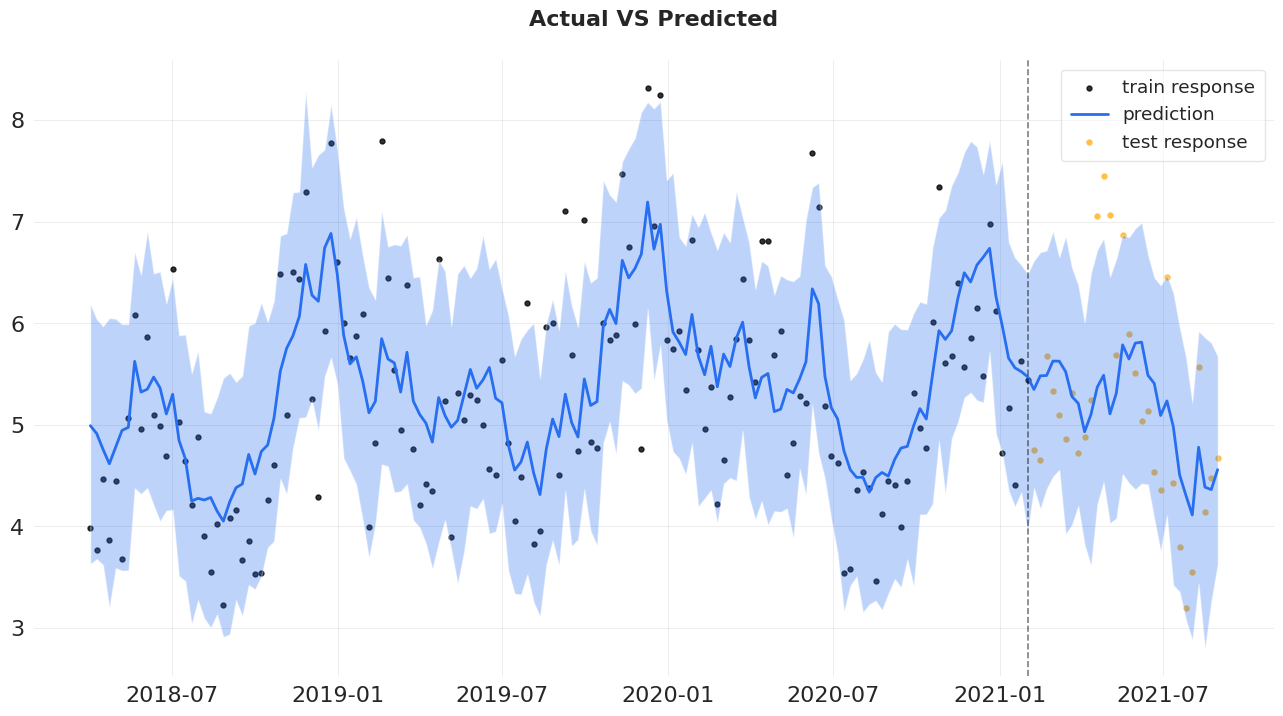

In [53]:
plot_predicted_data(df_ktr.iloc[:-test_size], pred, "ds", test_actual_df=df_ktr.iloc[-test_size:], actual_col="y", title="Actual VS Predicted");

In [54]:
ktr.fit(df_ktr)
y_pred = ktr.predict(df_ktr)["prediction"].values

2023-09-28 20:20:26 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-09-28 20:20:26 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-09-28 20:20:26 - orbit - INFO - step    0 loss = 270.23, scale = 0.086368
INFO:orbit:step    0 loss = 270.23, scale = 0.086368
2023-09-28 20:20:28 - orbit - INFO - step  100 loss = 217.76, scale = 0.086656
INFO:orbit:step  100 loss = 217.76, scale = 0.086656
2023-09-28 20:20:30 - orbit - INFO - step  200 loss = 213.06, scale = 0.095256
INFO:orbit:step  200 loss = 213.06, scale = 0.095256
2023-09-28 20:20:32 - orbit - INFO - step  300 loss = 213.41, scale = 0.10117
INFO:orbit:step  300 loss = 213.41, scale = 0.10117


In [55]:
performance_df[MODEL_NAME] = evaluate_model(df[LABEL], y_pred).values()
param_df[MODEL_NAME] = param_df["pymc-marketing"]
param_df.loc[["beta_1", "beta_2"], MODEL_NAME] = ktr.get_regression_coefs()[CHANNELS].mean().round(2).values

In [56]:
param_df[MODEL_NAME]

alpha1    0.29
alpha2    0.32
mu1       4.64
mu2       2.89
beta_1    2.59
beta_2    3.55
Name: stacked, dtype: float64

The expected value of the posterior distributions is:

|       |$$\mathbb{E}[\hat{\mu}]$$|$$\mathbb{E}[\hat{\alpha}]$$| $$\mathbb{E}[\hat{\beta}]$$       |
| ------| ----------------------- | -------------------------- |---------------------------------- |
| $X_1$ |        4.66             |            0.29            |                3.22               |
| $X_2$ |        2.86             |            0.32            |                3.81               |

In [57]:
pred = ktr.predict(df_ktr, decompose=True)
pred["actual"] = df[LABEL]
y_pred = pred["prediction"].values

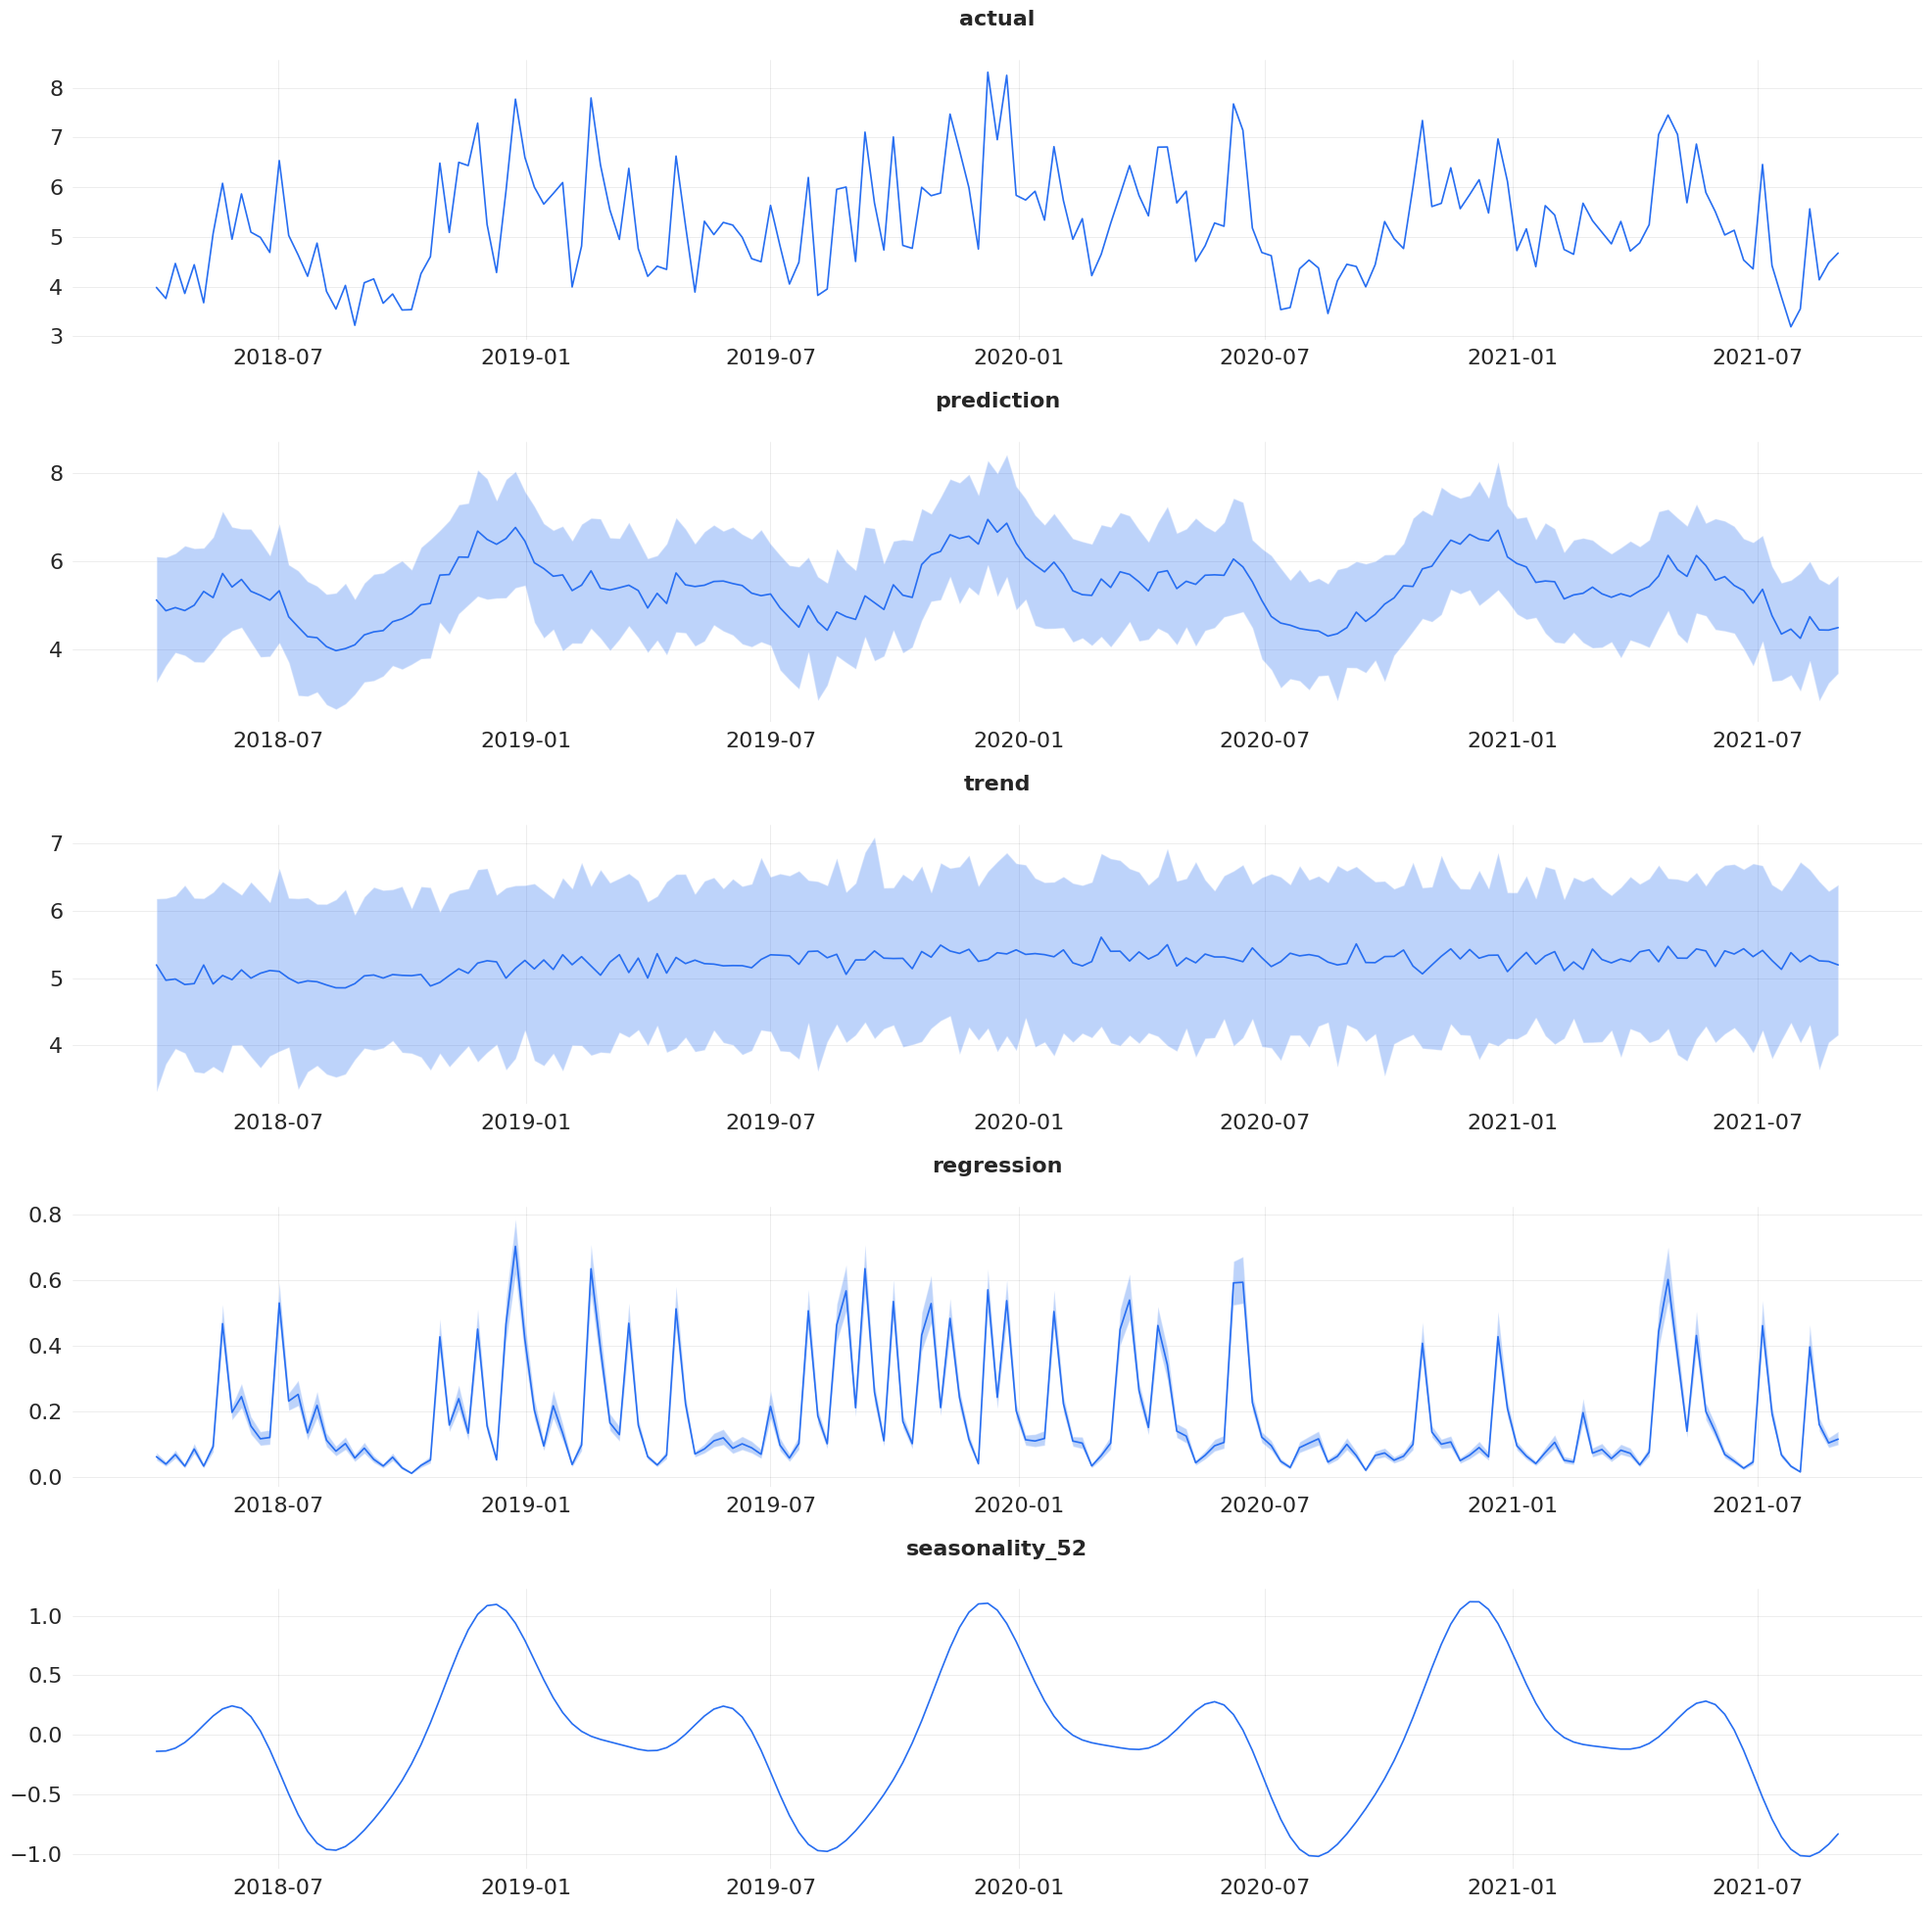

In [58]:
plot_predicted_components(
    pred,
    "ds",
    plot_components=["actual", "prediction", "trend", "regression", "seasonality_52"],
    figsize=(20, 20),
);

In [59]:
param_df[MODEL_NAME] = param_df["pymc-marketing"]
param_df.loc[["beta_1", "beta_2"], MODEL_NAME] = (
    ktr.get_regression_coefs()[CHANNELS].mean().round(2).values
)

# Summary

In [60]:
roas_df

,actual,pymc-marketing,ktr
x1,4.967832,4.399478,0.544602
x2,2.274883,2.472261,1.416823


In [61]:
print(param_df.to_markdown())

|        |   actual |   pymc-marketing | ktr   |   stacked |
|:-------|---------:|-----------------:|:------|----------:|
| alpha1 |      0.4 |             0.29 | -     |      0.29 |
| alpha2 |      0.2 |             0.32 | -     |      0.32 |
| mu1    |      4   |             4.64 | -     |      4.64 |
| mu2    |      3   |             2.89 | -     |      2.89 |
| beta_1 |      3   |             0.32 | 0.54  |      2.59 |
| beta_2 |      2   |             0.23 | 1.42  |      3.55 |


|            |   actual |   PyMC-Marketing | KTR   |   Our Model |
|:-----------|---------:|-----------------:|:------|----------:|
| $\hat{\alpha_1}$ |      0.4 |             0.29 | -     |      0.29 |
| $\hat{\alpha_2}$ |      0.2 |             0.32 | -     |      0.32 |
| $\hat{\mu_1}$    |      4   |             4.66 | -     |      4.66 |
| $\hat{\mu_2}$    |      3   |             2.86 | -     |      2.86 |
| $\hat{\beta_1}$  |      3   |             0.32 | 0.54  |      2.72 |
| $\hat{\beta_2}$  |      2   |             0.23 | 1.42  |      4.6  |

In [62]:
print(performance_df.to_markdown())

|      |   pymc-marketing |   ktr |   stacked |
|:-----|-----------------:|------:|----------:|
| r2   |            0.898 | 0.715 |     0.52  |
| mape |            0.056 | 0.094 |     0.117 |
| mase |            0.281 | 0.449 |     0.595 |


|           |  PyMC-Marketing | KTR   | Our Model |
|:----------|----------------:|------:|----------:|
| $$R^2$$   |      0.898      | 0.715 |   0.552   |
| $$MAPE$$  |      0.056      | 0.094 |   0.116   |
| $$MASE$$  |      0.281      | 0.449 |   0.593   |
